In [29]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVC  # support vector machines classification
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier # neural network for classification
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost for classification
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib
import matplotlib.pyplot as plt



In [30]:
import pandas as pd
import random
import math

# read in time point 1 for training
# train on it - model 1
# test on tp 2
# read tp 2
# add it to xgb - model 2
# test on tp 3
# read tp 3
# add it to xgb - model 3
# test on tp 4
# test model 1
data = pd.read_csv('data_no_2022_synthesized_nonstationary.csv')
data.head()

,yield,radiation,rain,avg_min_temp,avg_max_temp,class
0,1.023000,275390.830000,2894.760000,4.541100,15.091400,0
1,0.664000,376919.090000,3809.250000,3.900000,14.461900,0
2,0.753915,332233.082103,3701.896711,4.294864,14.813671,0
3,1.023283,351347.713259,2833.443042,4.530492,14.704714,0
4,0.867145,260180.352724,3661.022839,3.897179,14.343613,0


In [31]:
print(len(data))

20012


In [32]:
data = data.rename(columns={'Yield (tons/acre)':'yield'})

In [33]:
xColumnsToKeep = ["radiation","rain", "avg_max_temp", "avg_min_temp"]

# the target to keep
yColumnsToKeep = ["yield"]

# get a dataframe containing the features and the targets
xDf = data[xColumnsToKeep]


yDf = data[yColumnsToKeep]


In [35]:
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
import numpy as np

# Define the number of features to select (e.g., you can set it as an integer or a percentage)
features = 4  # Example: Select top 3 features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(xDf, yDf, test_size=0.2, random_state=42)

# Extract the first column from y_test and flatten it
y_test_flat = y_test.iloc[:, 0].values  # Use .iloc to select the first column and convert to 1D array

# Standardization
standardScaler = preprocessing.StandardScaler()

# Feature Selection
if type(features) == int:
    featureSelection = SelectKBest(f_regression, k=features)
elif type(features) == float:
    featuresPercentile = features / 100.0
    featureSelection = SelectPercentile(f_regression, percentile=featuresPercentile)
else:
    raise ValueError("The input 'features' is not an integer or a float. It should be.")

# Define the pipeline with standardization, feature selection, and the model
pipe = Pipeline(steps=[
    ('standardization', standardScaler),
    ('feature selection', featureSelection),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'))
])

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }
    
    # Update the pipeline model with the hyperparameters from Optuna trial
    pipe.set_params(model__n_estimators=param['n_estimators'],
                    model__max_depth=param['max_depth'],
                    model__learning_rate=param['learning_rate'],
                    model__subsample=param['subsample'],
                    model__colsample_bytree=param['colsample_bytree'],
                    model__gamma=param['gamma'],
                    model__min_child_weight=param['min_child_weight'],
                    model__reg_alpha=param['reg_alpha'],
                    model__reg_lambda=param['reg_lambda'])

    # Train the model on the training data
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)
    
    # Evaluation metrics
    mae = mean_absolute_error(y_test_flat, y_pred)
    r2 = r2_score(y_test_flat, y_pred)
    
    # Pearson's Correlation Coefficient (R)
    correlation_matrix = np.corrcoef(y_test_flat, y_pred)
    correlation = correlation_matrix[0, 1]
    
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    def smape(y_true, y_pred):
        denominator = np.abs(y_true) + np.abs(y_pred)
        diff = np.abs(y_true - y_pred) / denominator
        diff[denominator == 0] = 0.0  # Handle the case where both true and predicted values are zero
        return 100 * np.mean(diff)
    
    smape_value = smape(y_test_flat, y_pred)
    
    # Composite objective: maximize R² and correlation, minimize MAE and SMAPE
    # We subtract MAE and SMAPE to minimize them and add R² and correlation to maximize them
    
    
    # Return the objective value to Optuna
    return mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')  # Maximize the combined objective
study.optimize(objective, n_trials=100)  # Perform 100 trials

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best hyperparameters
pipe.set_params(model__n_estimators=best_params['n_estimators'],
                model__max_depth=best_params['max_depth'],
                model__learning_rate=best_params['learning_rate'],
                model__subsample=best_params['subsample'],
                model__colsample_bytree=best_params['colsample_bytree'],
                model__gamma=best_params['gamma'],
                model__min_child_weight=best_params['min_child_weight'],
                model__reg_alpha=best_params['reg_alpha'],
                model__reg_lambda=best_params['reg_lambda'])

pipe.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = pipe.predict(X_test)

# Print evaluation metrics
mae = mean_absolute_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)
correlation_matrix = np.corrcoef(y_test_flat, y_pred)
correlation = correlation_matrix[0, 1]
smape_value = smape(y_test_flat, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² (Coefficient of Determination): {r2}')
print(f'Pearson\'s Correlation Coefficient (R): {correlation}')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value}')


[I 2025-04-19 13:48:41,534] A new study created in memory with name: no-name-bcb43051-6db6-449c-b21a-1e19fd51f2bc
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-04-19 13:48:41,646] Trial 0 finished with value: 0.1968356545062947 and parameters: {'n_estimators': 87, 'max_depth': 3, 'learning_rate': 0.04830727054707626, 'subsample': 0.5847999205280325, 'colsample_bytree': 0.5028156542585327, 'gamma': 0.3379291569388716, 'min_child_weight': 4, 'reg_alpha': 0.470270724651054, 'reg_lambda': 0.6453008369652286}. Best is trial 0 with value: 0.1968356545062947.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d 

Best hyperparameters: {'n_estimators': 159, 'max_depth': 8, 'learning_rate': 0.08208414107486195, 'subsample': 0.9738603902083941, 'colsample_bytree': 0.8267446114329005, 'gamma': 0.09031964175492926, 'min_child_weight': 7, 'reg_alpha': 0.5901776928301206, 'reg_lambda': 0.5290748444701051}
Mean Absolute Error (MAE): 0.1781379394221687
R² (Coefficient of Determination): 0.7867924749574998
Pearson's Correlation Coefficient (R): 0.8870549918305369
Symmetric Mean Absolute Percentage Error (SMAPE): 6.046100725544448


In [36]:
target_yearDf=pd.read_csv('target_yearDf.csv')

In [37]:
print(len(target_yearDf))

8


In [38]:
xColumnsToKeep = ["radiation","rain", "avg_max_temp", "avg_min_temp"]

# the target to keep
yColumnsToKeep = ["yield"]

# get a dataframe containing the features and the targets
target_xDf = target_yearDf[xColumnsToKeep]


target_yDf = target_yearDf[yColumnsToKeep]

In [40]:
all_yearsDf=pd.read_csv("all_years.csv")

0.34563886221865314
R:  -0.0039487260125994446
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.167
Method:                 Least Squares   F-statistic:                 9.356e-05
Date:                Sat, 19 Apr 2025   Prob (F-statistic):              0.993
Time:                        13:49:29   Log-Likelihood:                -3.1777
No. Observations:                   8   AIC:                             10.36
Df Residuals:                       6   BIC:                             10.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_metrics/forecasting/_classes.py:657: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sktime/performance_m

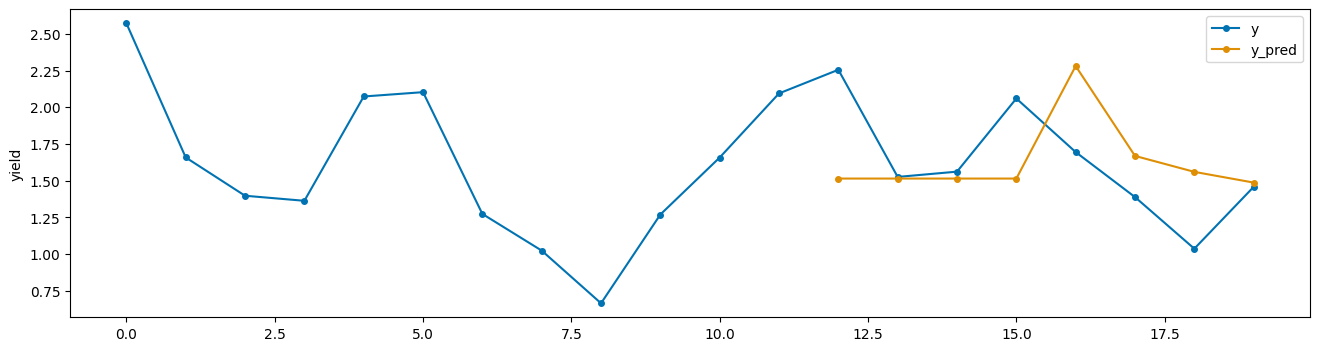

In [42]:
m1,r2=actualTest(all_yearsDf, target_yearDf, target_xDf, target_yDf, pipe)

In [41]:
def actualTest(all_yearsDf, target_yearDf, xTest, yTest, model):
    #print("Length of all_yearsDf----This is used for plotting graph ", len(all_yearsDf))
    #print("Length of final_yearDf-----This is used for adjusting the predicted values: ", len(final_yearDf))
    #print("Length of target_yearDf-------This is used for comparing predicted values to true values-----these are true values ", len(target_yearDf))
    #print("boost_xDf: ",len(boost_xDf))
    #print("boost_yDf: ", len(boost_yDf))
    #print("Length of xTest: ", len(xTest))
    #print("Length of yTest: ", len(yTest))
    #print("test results on our test data: ")
    #print(yTest)
    
    #model = model.fit(boost_xDf, boost_yDf, xgb_model=model.get_booster())
    # get predictions
    pred = model.predict(xTest)
    #trainPred = model.predict(xTrain)
    #print("Length of predictions are: ", len(pred))

    #adj_pred = []
    #for i in range(len(pred)):
    #    adj_pred.append(final_yearDf['yield'][i] + pred[i])
    #print('adjusted predictions: ')
    #print(adj_pred)
    #print("Predictions are: ")
    #print(pred)
    #print("Length of adjusted predictions: ", len(adj_pred))
    pred_Df = pd.DataFrame(pred)
    #print(adj_pred_Df)
    #adj_pred_Df=pd.DataFrame(pred)
    # find errors
    meanAbsoluteError = mean_absolute_error(target_yearDf['yield'], pred_Df)
    print(meanAbsoluteError)
#     plt.scatter(yTest, pred, label='Truth vs Prediction')
#     p1 = max(max(pred), max(yTest['Yield (tons/acre)']))
#     p2 = min(min(pred), min(yTest['Yield (tons/acre)']))
#     plt.plot([p1, p2], [p1, p2], color='k', label='Perfect Predictions')
#     plt.xlabel('True Yields')
#     plt.ylabel('Predicted Yields')
#     plt.legend()
    #print("Plotting--------")
    pred_ts = []
    len_tsDf = len(all_yearsDf)
    #print("len_tsDf----Length of all_yearsDf----", len_tsDf)
    for i in range(len_tsDf - len(pred), len_tsDf):
        pred_ts.append(i)
    #print("Length of pred_ts is: ", len(pred_ts))
    #print("This is the index calculated for plotting time-series graph: ", pred_ts)    
    pred_df = pd.DataFrame(pred, index = pred_ts, columns = ['yield'])
    #print("Lengths of all_yearsDf and Lengths of pred_Df are: ", len(all_yearsDf['yield']), len(pred_df))
    #print("Head and shape of pred_Df")
    #print(pred_df.head())  # Check structure
    #print(pred_df.shape)   # Compare with all_yearsDf
    #print(all_yearsDf.index)
    plot_series(pd.Series(all_yearsDf['yield']), pred_df, labels=["y", "y_pred"])


    #plt.figure(figsize=(10, 6))

    # Plot actual yield using its index
    #plt.plot(all_yearsDf.index, all_yearsDf['yield'], label="Actual Yield", linestyle="-", color="blue")

    # Plot predicted yield using its index (from pred_df)
    #plt.plot(pred_df.index, pred_df['yield'], label="Predicted Yield", linestyle="--", color="red")

    #plt.xlabel("Index")  # The x-axis will now be the index of each DataFrame
    #plt.ylabel("Yield")
    #plt.legend()
    #plt.title("Actual vs. Predicted Yield")
    #plt.show()

    # find the R values
    r = np.corrcoef(target_yearDf['yield'], pred)[0,1]
    print("R: ",r)
    # find the R^2 coefficient of determination
    # defining the variables
#     r2x = xTest.tolist()
#     r2y = yTest.tolist()

    # adding the constant term
    r2pred = sm.add_constant(pred)

    # performing the regression
    # and fitting the model
    yTargetYield = target_yearDf['yield']
    result = sm.OLS(yTargetYield, r2pred).fit()

    # printing the summary table
    print(result.summary())
    print('skt mape: ' + str(round(skt_mape(yTargetYield, pred_Df) * 100, 3)) + '%')
    print('skt smape: ' + str(round(skt_smape(yTargetYield, pred_Df) * 100, 3)) + '%')
    print('skt mae: ' + str(round(skt_mae(yTargetYield, pred_Df), 3)))
    print('skt mse: ' + str(round(skt_mse(yTargetYield, pred_Df), 3)))
    print('skt rmse: ' + str(round(math.sqrt(skt_mse(yTargetYield, pred_Df)), 3)) + '\n\n')
    
    #accuracy = accuracy_score(yTest, pred)
    
    return(meanAbsoluteError, r)
    

#     # add the errors and R Squared to average values
#     avgMAE += meanAbsoluteError
#     avgRSq += rSq

#     # check to see which metric should be optimized
#     if metricToOptimize == 'r2':
#         # check to see if any of these are the best values
#         if (rSq > bestRSq):
#             bestMAE = meanAbsoluteError
#             bestModel = model
#             bestRSq = rSq

#     elif metricToOptimize == 'mae':
#         # check to see if any of these are the best values
#         if (meanAbsoluteError < bestMAE):
#             bestMAE = meanAbsoluteError
#             bestModel = model
#             bestRSq = rSq

#     else:
#         raise ValueError("The input 'metricToOptimize' does not have a valid input. It must be 'r2' or 'mae'.")

In [27]:
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import joblib
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import math

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sktime.utils.plotting import plot_series

# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, matthews_corrcoef
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVR  # support vector machines regression
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import AdaBoostRegressor # adaboost for regression
import xgboost as xgb

skt_mape = MeanAbsolutePercentageError(symmetric=False)
skt_smape = MeanAbsolutePercentageError(symmetric=True)
skt_mae = MeanAbsoluteError()
skt_mse = MeanSquaredError()